## 4.3 如何生成自己的TFRecord格式数据
	上节我们介绍了TFRecord格式的一些优点，那么，如何把一般格式的数据，如图像、文本等格式数据，转换为TFRecord格式数据呢？这里通过介绍一个把有关小猫和小狗的jpg格式的图像转换为TFRecord文件，然后读取转换后的数据的例子，帮助你了解如何生成自己的TFRecord格式数据。

### 4.3.1 把数据转换为TFRecord格式的一般步骤
	把非TFRecord格式数据转换为TFRecord格式数据的一般步骤，如图4-2所示。
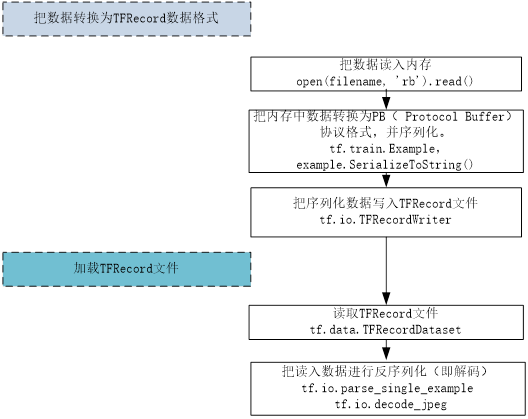
    <center>图4-2 转换成TFRecord格式的一般步骤</center>
	在数据转换过程中，Example是TFReocrd的核心，TFReocrd包含一系列Example，每个Example可以认为是一个样本。Example是Tensorflow的对象类型，可通过tf.train.example来使用。
	Example含义： 如表4-2所示，假设有样本（x，y） ：输入x 和 输出y一起叫作样本。这里每个x是六维向量，每个y是一维向量。

1）表征 (representation)：x集合了代表个人的全部特征。其中特征 (feature)：x中的某个维度：如学历，年龄，职业。是某人的一个特点。
2）标签 (label)：y为输出。

|表4-2 一个样本格式|
|------------------|

|x||||||y|
|:----|:----|:----|:----|:------|:--------|:----------|
|学历	|   |        |年龄|	职业|	是否结婚|	收入|
|高中	|大学	|研究生|		|  |           |
|普通	|本科	|硕士	 |28  |	算法工程师|	已婚|	26000|

要存储表4-2中的数据，通常我们把输入表征x与标签y分开进行保存。假设有100个样本，把所有输入存储在100x6的numpy矩阵中，把标签存储在100x1的向量中。
Example协议块格式：

以TFRecord方式存储，输入和标签将以字典方式存放在一起，具体格式如图4-3所示。
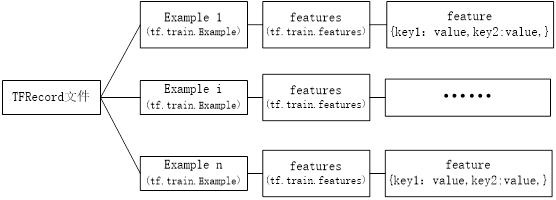
<center> 图4-3 TFRecord文件的存储格式</center>

### 4.3.2 加载TFRecord文件流程
生成TFRecord文件后，我们可以通过tf.data来生成一个迭代器，设置每次调用都返回一个大小为batch_size的batch。可以通过TensorFlow的两个重要的函数读取TFRecord文件，如图4-4所示，分别是读取器（Reader）tf.data.TFRecordDataset和解码器（Decoder）tf.io.parse_single_example。
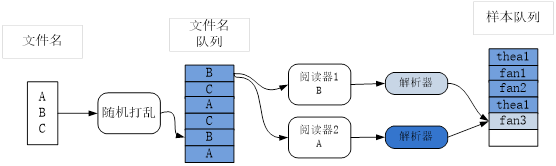
<center>图4-4 加载TFRecord文件流程</center>

### 4.3.3 代码实现
	生成TFRecord格式数据的完整过程为：
- 先把源数据（可以是文本、图像、音频、Embedding等，这里是小猫、小狗的图像）导入内存（如NumPy）；
- 把内存数据转换为TFRecord格式数据；
- 读取TFRecord数据。  
1）导入模块及数据。

In [1]:
import tensorflow as tf
import os

data_dir = "../data/cat-dog"
train_cat_dir = data_dir + '/train/cats/'
train_dog_dir = data_dir + "/train/dogs/"
train_tfrecord_file = data_dir + "/train/train.tfrecords"

test_cat_dir = data_dir + "/test/cats/"
test_dog_dir = data_dir + "/test/dogs/"
test_tfrecord_file = data_dir + "/test/test.tfrecords"

train_cat_filenames = [train_cat_dir + filename for filename in os.listdir(train_cat_dir)]
train_dog_filenames = [train_dog_dir + filename for filename in os.listdir(train_dog_dir)]
train_filenames = train_cat_filenames + train_dog_filenames
train_labels = [0]*len(train_cat_filenames) + [1]*len(train_dog_filenames)

test_cat_filenames = [test_cat_dir + filename for filename in os.listdir(test_cat_dir)]
test_dog_filenames = [test_dog_dir + filename for filename in os.listdir(test_dog_dir)]
test_filenames = test_cat_filenames + test_dog_filenames
test_labels = [0]*len(test_cat_filenames) + [1]*len(test_dog_filenames)

2）把数据转换为TFRecord格式。

In [2]:
def encoder(filenames, labels, tfrecord_file):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in zip(filenames, labels):
            image = open(filename, 'rb').read()

            # 建立feature字典，这里特征image，label都以向量方式存储
            feature = {
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }

            # 通过字典创建example，example对象对label和image数据进行封装
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # 将example序列化并写入字典
            writer.write(example.SerializeToString())

encoder(train_filenames, train_labels, train_tfrecord_file)
encoder(test_filenames, test_labels, test_tfrecord_file)

3）从TFRecord读取数据。  
这里使用 tf.data.TFRecordDataset类来读取TFRecord文件。TFRecordDataset 对于标准化输入数据和优化性能十分有用。可以使用tf.io.parse_single_example函数对每个样本进行解析（tf.io.parse_example用于对批量样本进行解析）。 注意，这里的 feature_description 是必需的，因为数据集使用计算图方式执行，需要这些描述来构建它们的形状和类型签名。  
可以使用 tf.data.Dataset.map 方法将函数应用于数据集的每个元素。

In [3]:
def decoder(tfrecord_file, is_train_dataset=None):
    #构建dataset
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    #说明特征的描述属性，为解吗每个example使用
    feature_discription = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    def _parse_example(example_string): # 解码每一个example
        #将文件读入到队列中
        feature_dic = tf.io.parse_single_example(example_string, feature_discription)
        feature_dic['image'] = tf.io.decode_jpeg(feature_dic['image'])
        #对图片进行resize
        feature_dic['image'] = tf.image.resize(feature_dic['image'], [256, 256])/255.0
        #tf.image.random_flip_up_down(image).shape        
        return feature_dic['image'], feature_dic['label']

    batch_size = 4

    if is_train_dataset is not None:
        #tf.data.experimental.AUTOTUNE#根据计算机性能进行运算速度的调整
        dataset = dataset.map(_parse_example).shuffle(buffer_size=2000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.map(_parse_example)
        dataset = dataset.batch(batch_size)

    return dataset

train_data = decoder(train_tfrecord_file, 1)
test_data = decoder(test_tfrecord_file)


4）可视化读取的数据。

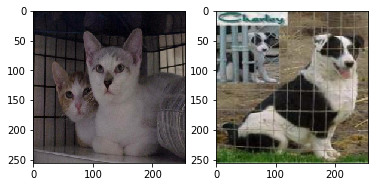

In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline
#查看dataset中样本的具体信息
i=1
for image,lable in train_data:
    plt.subplot(1,2,i)
    plt.imshow(image[0].numpy())
    i+=1
    if i==3:
        break
plt.show()


图4-5 解码TFRecord数据的示意图